In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and select your products.csv

Saving NVDA_stock_features.csv to NVDA_stock_features.csv


In [ ]:
# 1. Load Data
# ------------------------------
def load_data(ticker):
    df = pd.read_csv(f"{ticker}_stock_features.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

ticker = "NVDA"  # Change this to your stock symbol like "NVDA"
df = load_data(ticker)

features = ['Close', 'MA10', 'RSI', 'Norm_Volume', 'Bollinger_Upper', 'Bollinger_Lower']
df = df[features]


In [ ]:
# 2. Scaling
# ------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [ ]:
# 3. Sequence Generation
# ------------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting "Close"
    return np.array(X), np.array(y)

sequence_length = 100
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
# 4. Train-Test Split
# ------------------------------
split_index = int(0.7 * len(X))
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

In [ ]:
# Learning Rate Scheduler (Exponential Decay)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Optimizer with scheduler
custom_adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

# Build the model
model = Sequential([
    Bidirectional(LSTM(units=50, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    Bidirectional(LSTM(units=60, activation='tanh', return_sequences=True)),
    Dropout(0.2),

    Bidirectional(LSTM(units=80, activation='tanh', return_sequences=True)),
    Dropout(0.25),

    Bidirectional(LSTM(units=120, activation='tanh')),
    Dropout(0.3),

    Dense(units=1)
])

# Compile the model
model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 862ms/step - loss: 0.0208 - mae: 0.1129 - val_loss: 0.0554 - val_mae: 0.1997
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 726ms/step - loss: 0.0052 - mae: 0.0591 - val_loss: 0.0255 - val_mae: 0.1327
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 865ms/step - loss: 0.0028 - mae: 0.0417 - val_loss: 0.0356 - val_mae: 0.1600
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 670ms/step - loss: 0.0019 - mae: 0.0324 - val_loss: 0.0205 - val_mae: 0.1173
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 741ms/step - loss: 0.0017 - mae: 0.0328 - val_loss: 0.0205 - val_mae: 0.1151
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 731ms/step - loss: 0.0022 - mae: 0.0363 - val_loss: 0.0439 - val_mae: 0.1775
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 810ms/step - loss: 0.0021 - mae: 0.0349 - val_loss: 0.0216 - val_mae: 0.1189
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 762ms/step - loss: 0.0017 - mae: 0.0328 - val_loss: 0.0211 - val_mae: 0.1169
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
# 6. Prediction
# ------------------------------
y_pred = model.predict(X_test)

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

In [ ]:
# 7. Inverse Scaling
# ------------------------------
scale_factor = 1 / scaler.scale_[0]
y_pred_rescaled = y_pred * scale_factor
y_test_rescaled = y_test * scale_factor

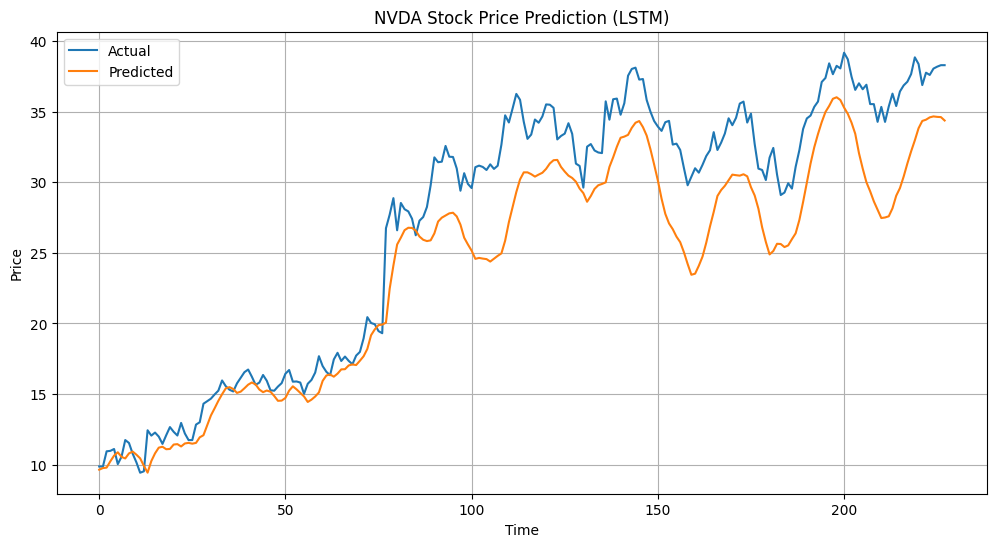

In [ ]:
# 8. Plotting
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title(f'{ticker} Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 9. MAE
# ------------------------------
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 7.964559014312028


In [ ]:
# 10. Actual vs. Predicted Table
# ------------------------------
df_results = pd.DataFrame({
    'Actual Price': y_test_rescaled.flatten(),
    'Predicted Price': y_pred_rescaled.flatten()
})
print(df_results.head(15))

    Actual Price  Predicted Price
0      51.568832        52.173643
1      50.840408        50.341903
2      47.739716        47.744724
3      52.503967        44.871692
4      56.618484        44.737577
5      58.173752        46.351697
6      55.496338        47.782929
7      55.053375        48.466518
8      53.695007        49.117843
9      50.023392        49.730596
10     55.269958        49.304327
11     62.032440        50.831050
12     66.609619        53.953410
13     77.201172        56.716698
14     80.380585        62.354249
